In [1]:
import prettymaps
import pandas as pd
import json
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, Polygon
import datetime
import itertools
import os
import glob
from shapely.geometry import MultiPolygon, Polygon, Point, MultiPoint, LineString
from shapely.ops import split
from pyproj import Geod

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
COMMUNES_FILE = 'data/communes-martinique.geojson'

WOMEN_COLOR = "#470083"
MEN_COLOR = "#589c48"

In [3]:
PRIMARY_LIST = 'Liste principale' # primaire = FR, #
def fix_date(s, where):
    if s[where:where + 2] == '00':
        s = s[:where] + '01' + s[where+2:]
    return s

def fix_date_or_fail(str_date, retry=True):
    str_date_fixed = fix_date(fix_date(str_date, 0), 3)
    try:
        return datetime.datetime.strptime(str_date_fixed, '%d/%m/%Y').date()
    except ValueError:
        return None


dfs = []
for filename in glob.glob('../../../mq/liste-electorale/data/*'):
    df = pd.read_csv(
        filename, sep=';', 
        dtype={'code de la commune de naissance':str, 'code du département de naissance':str, },
        parse_dates=['date du premier tour', 'date du second tour', 'date de naissance'], date_parser=fix_date_or_fail,
    )
    df['code'] = int(filename.split('/')[-1].split('-')[1][-5:])
    dfs.append(df)
df = pd.concat(dfs)

In [4]:
genders = (df[['code', 'sexe']]
           .drop_duplicates()
           .merge(df[['code', 'sexe']].groupby(by=['code', 'sexe']).agg(total_gender=('sexe', 'count')), on=['code', 'sexe'])
           .merge(df[['code', 'sexe']].groupby(by=['code']).agg(total=('sexe', 'count')), on=['code']))
genders['proportion'] = genders['total_gender'] / genders['total']
genders

,code,sexe,total_gender,total,proportion
0,97220,F,5885,10982,0.535877
1,97220,M,5097,10982,0.464123
2,97205,M,1560,3443,0.453093
3,97205,F,1883,3443,0.546907
4,97217,F,3615,6889,0.524750
...,...,...,...,...,...
63,97232,F,4236,8060,0.525558
64,97222,M,8492,18091,0.469405
65,97222,F,9599,18091,0.530595
66,97210,M,7527,16207,0.464429


In [5]:
gdf_mq = gpd.read_file(COMMUNES_FILE)
gdf_mq.code = gdf_mq.code.astype(int)
initial_crs = gdf_mq.geometry.crs.srs
gdf_mq = gdf_mq.merge(genders.loc[genders.sexe == 'F'], on='code')                

In [6]:

gdf_mq

,code,nom,geometry,sexe,total_gender,total,proportion
0,97201,Ajoupa-Bouillon,"POLYGON ((-61.14848 14.80590, -61.15340 14.805...",F,793,1525,0.520000
1,97202,Anses-d'Arlet,"MULTIPOLYGON (((-61.05330 14.45579, -61.05472 ...",F,1680,3293,0.510173
2,97203,Basse-Pointe,"POLYGON ((-61.16381 14.81601, -61.16249 14.818...",F,1704,3328,0.512019
3,97204,Carbet,"POLYGON ((-61.16765 14.67530, -61.16847 14.676...",F,1666,3145,0.529730
4,97205,Case-Pilote,"POLYGON ((-61.11754 14.62759, -61.11877 14.628...",F,1883,3443,0.546907
5,97206,Diamant,"MULTIPOLYGON (((-61.05793 14.50678, -61.05356 ...",F,2773,5245,0.528694
6,97207,Ducos,"POLYGON ((-61.00063 14.55991, -61.00108 14.560...",F,7304,13338,0.547608
7,97208,Fonds-Saint-Denis,"POLYGON ((-61.12165 14.71927, -61.12344 14.719...",F,326,675,0.482963
8,97209,Fort-de-France,"POLYGON ((-61.10080 14.69536, -61.09925 14.697...",F,34397,60578,0.567813
9,97210,François,"MULTIPOLYGON (((-60.93572 14.58822, -60.93520 ...",F,8680,16207,0.535571


In [7]:
all_data = []
geod = Geod(ellps="WGS84")
how = "left"
for city_id in range(34):
    city = gdf_mq.loc[city_id]['geometry']
    nom = gdf_mq.loc[city_id]['nom']
    target_ratio = gdf_mq.loc[city_id]['proportion']
    bounds = city.bounds

    p1 = Point(bounds[0],bounds[-1])
    p2 = Point(bounds[0],bounds[1])
    p3 = Point(bounds[-2],bounds[1])
    p4 = Point(bounds[-2],bounds[-1])
    point_list = [p1, p2, p3, p4, p1]
    bounds_poly = Polygon(point_list)

    base_h = bounds[3]
    height = bounds[1] - bounds[3]
    base_l = bounds[0]
    width = bounds[2] - bounds[0]

    ratio_min = (0, 0)
    ratio_max = (1, 1)
    epsilon = 0.005
    # lets try to find iteratively a proportion very close to the target, up to a very small difference.
    for i in range(20):
        ratio = (ratio_min[0] + ratio_max[0]) / 2

        if how == 'up':
            split_a = (bounds[0], base_h + height * ratio)
            split_b = (bounds[2], base_h + height * ratio)
        else:
            split_a = (base_l + width * ratio, bounds[1])
            split_b = (base_l + width * ratio, bounds[3])
            

        # here, you can also have more than 2 polygons, thanks captain obvious
        line = LineString([split_a, split_b])

        boundaries = split(bounds_poly, line)
        collection_of_polygons = split(city, line)

        group1, group2 = [],[]
        for p in collection_of_polygons.geoms:
            if p.within(boundaries.geoms[0]):
                group1.append(p)
            else:
                group2.append(p)
        group_multi1 = MultiPolygon(group1)
        group_multi2 = MultiPolygon(group2)

        areas_a, areas_b = geod.geometry_area_perimeter(group_multi1), geod.geometry_area_perimeter(group_multi2)

        area_ratio = areas_a[0] / (areas_a[0] + areas_b[0])
        if area_ratio < target_ratio * (1 - epsilon):
            ratio_min = (ratio, area_ratio)
        elif area_ratio > target_ratio * (1 + epsilon):
            ratio_max = (ratio, area_ratio)
        else:
            break

    if target_ratio == 0:
        all_data.append(gpd.GeoDataFrame(data={"code": city_id, "geometry":group_multi2, "t": "white"})) # white makes the output even worst !
    else:
        all_data += [
            gpd.GeoDataFrame(data={"code": city_id, "geometry":group_multi1, "t": WOMEN_COLOR, "gender": "F"}),
            gpd.GeoDataFrame(data={"code": city_id, "geometry":group_multi2, "t": MEN_COLOR, "gender": "M"})
        ]

X = gpd.GeoDataFrame(pd.concat(all_data, ignore_index=True), crs=all_data[0].crs)

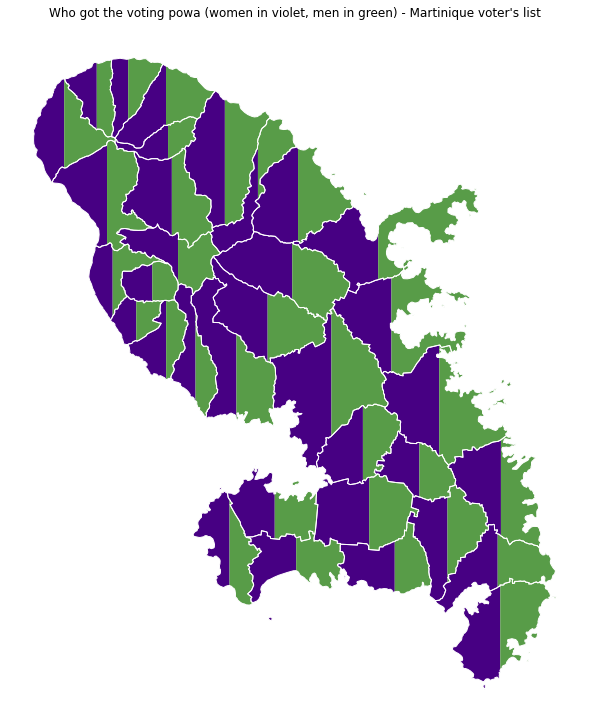

In [9]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle("Who got the voting powa (women in violet, men in green) - Martinique voter's list")

X.plot(ax=ax, legend=True, figsize=(15,15), linewidth=0, edgecolor='white', color=X["t"])
gdf_mq.boundary.plot(ax=ax, linewidth=1, edgecolor='white')

_ = ax.axis('off')
fig.savefig('output/2022-11-25.png', facecolor='white')